In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from networkx.algorithms import bipartite
import graphing_helper
from test_and_graphing import community_detection, community_strength
from helper_functions import find_clusters, reorder_cosine_matrix, compute_cosine_matrix, detect_cluster_structure_old
from cluster_detection import detect_cluster_structure
from elbow_detection import calc_elbow
from sklearn.cluster import KMeans
from IPython.display import display

In [2]:
def draw_graph(A:np.ndarray, group_labels=None, top_nodes=None):
    pos = None
    G = nx.from_numpy_array(A)
    if top_nodes is not None:
        bottom_nodes = set(G.nodes()) - top_nodes
        nx.set_node_attributes(G, {n: 0 for n in top_nodes}, name='bipartite')
        nx.set_node_attributes(G, {n: 1 for n in bottom_nodes}, name='bipartite')
        pos = nx.bipartite_layout(G, top_nodes)
    else: 
        pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, edge_color="black")

# graph structure

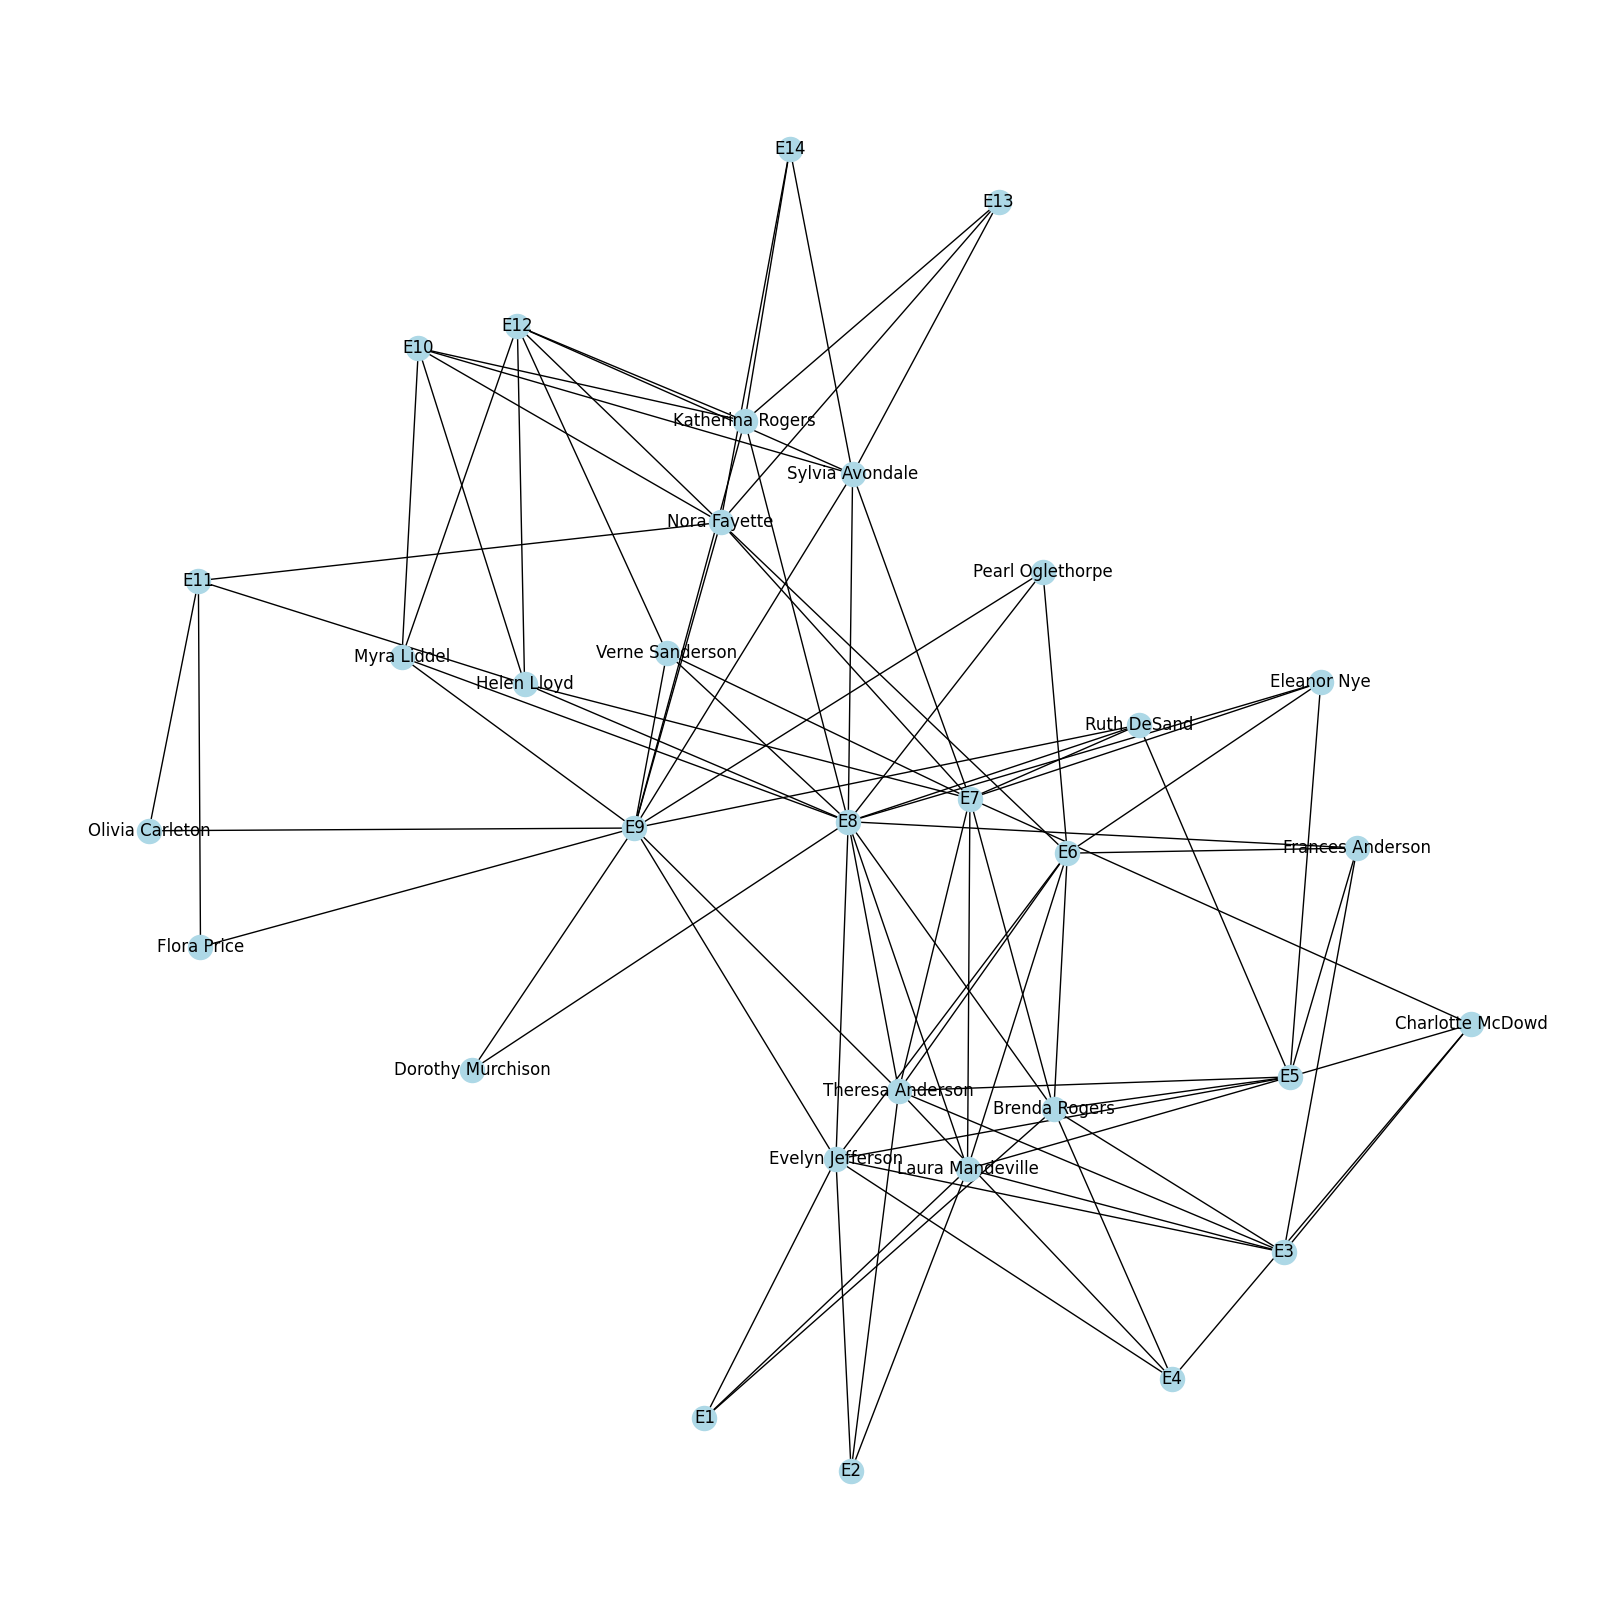

In [3]:
# AL = {
#     0: [1,3,2],
#     1: [0,2,3],
#     2: [1,3,0],
#     3: [0,2,4,6,1,5],
#     4: [3,5,6],
#     5: [4,6,3],
#     6: [3,5,4],
# }

# AL = {
#     0: [1,2,3,6],
#     1: [0,2],
#     2: [0,1],
#     3: [4,5,0,6],
#     4: [3,5],
#     5: [3,4],
#     6: [7,8,0,3],
#     7: [6,8],
#     8: [6,7]
# }

AL = nx.to_dict_of_lists(nx.davis_southern_women_graph())
# AL = nx.to_dict_of_lists(nx.karate_club_graph())
# AL = nx.to_dict_of_lists(nx.watts_strogatz_graph(n=100, k=6, p=0.05))

# top_nodes, bottom_nodes = bipartite.sets(nx.davis_southern_women_graph())

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos=pos, with_labels=True, edge_color="black", node_color='lightblue')

# Doing an SVD decomposition on the |L|= D + A

In [4]:
L_ABS = D + A
U, S, Vt = np.linalg.svd(L_ABS)
V = Vt.T
S = np.diag(S)

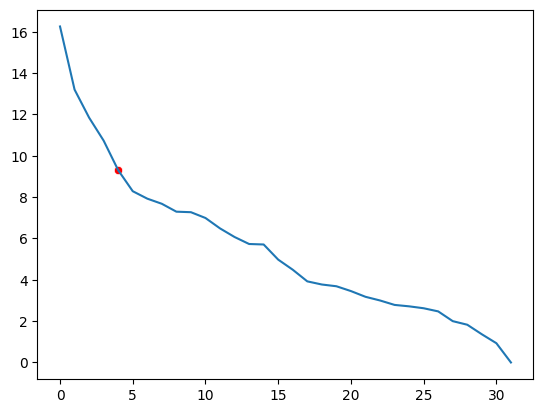

In [5]:
svs = np.diag(S)
k = calc_elbow(svs)
sns.lineplot(svs)
sns.scatterplot(x=[k], y=[svs[k]], color='red')
plt.show()

In [6]:
# k = 5
U_k = U[:,0:k+1]
S_k = S[0:k+1,0:k+1]
V_k = V[:,0:k+1]

# Compute and reorder cosine matrix

In [7]:
CM = compute_cosine_matrix(S_k, V_k, m, n)
(CM_REORDERED, INDEX) = reorder_cosine_matrix(CM=CM, index=True)

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

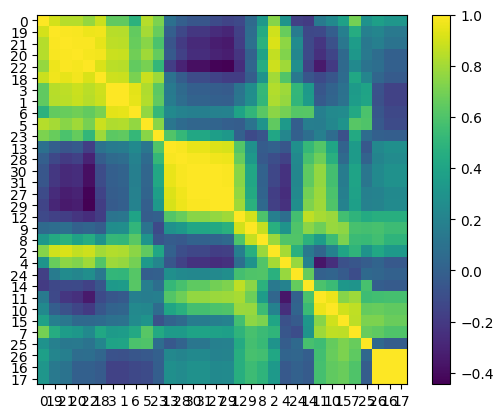

In [8]:
# print(INDEX)
# for r in range(CM_REORDERED.shape[0]):
#     line = ""
#     for c in range(CM_REORDERED.shape[1]):
#         line += str(CM_REORDERED[r,c])
#         if (c < CM_REORDERED.shape[1] - 1):
#             line += ","
#     print(line)

import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show() #17-25

# trying to algorithmically find the clusters

[range(0, 11), range(11, 18), range(16, 19), range(17, 20), range(18, 21), range(19, 23), range(24, 29), range(29, 32)]


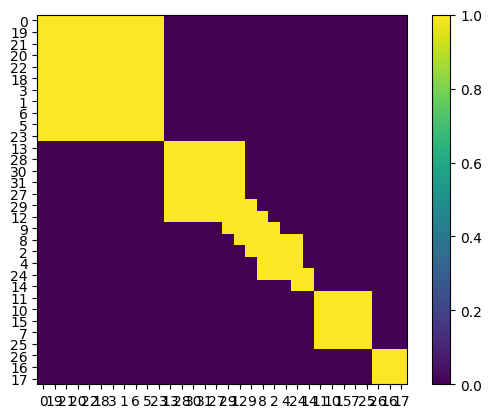

In [9]:
cluster_result = detect_cluster_structure(CM_REORDERED, 0.05)
clusters = find_clusters(cluster_result)
print(clusters)
plt.imshow(cluster_result, cmap='viridis')
plt.xticks(range(len(INDEX)), INDEX)
plt.yticks(range(len(INDEX)), INDEX)
plt.colorbar()
plt.show()

# Visualize Clusters

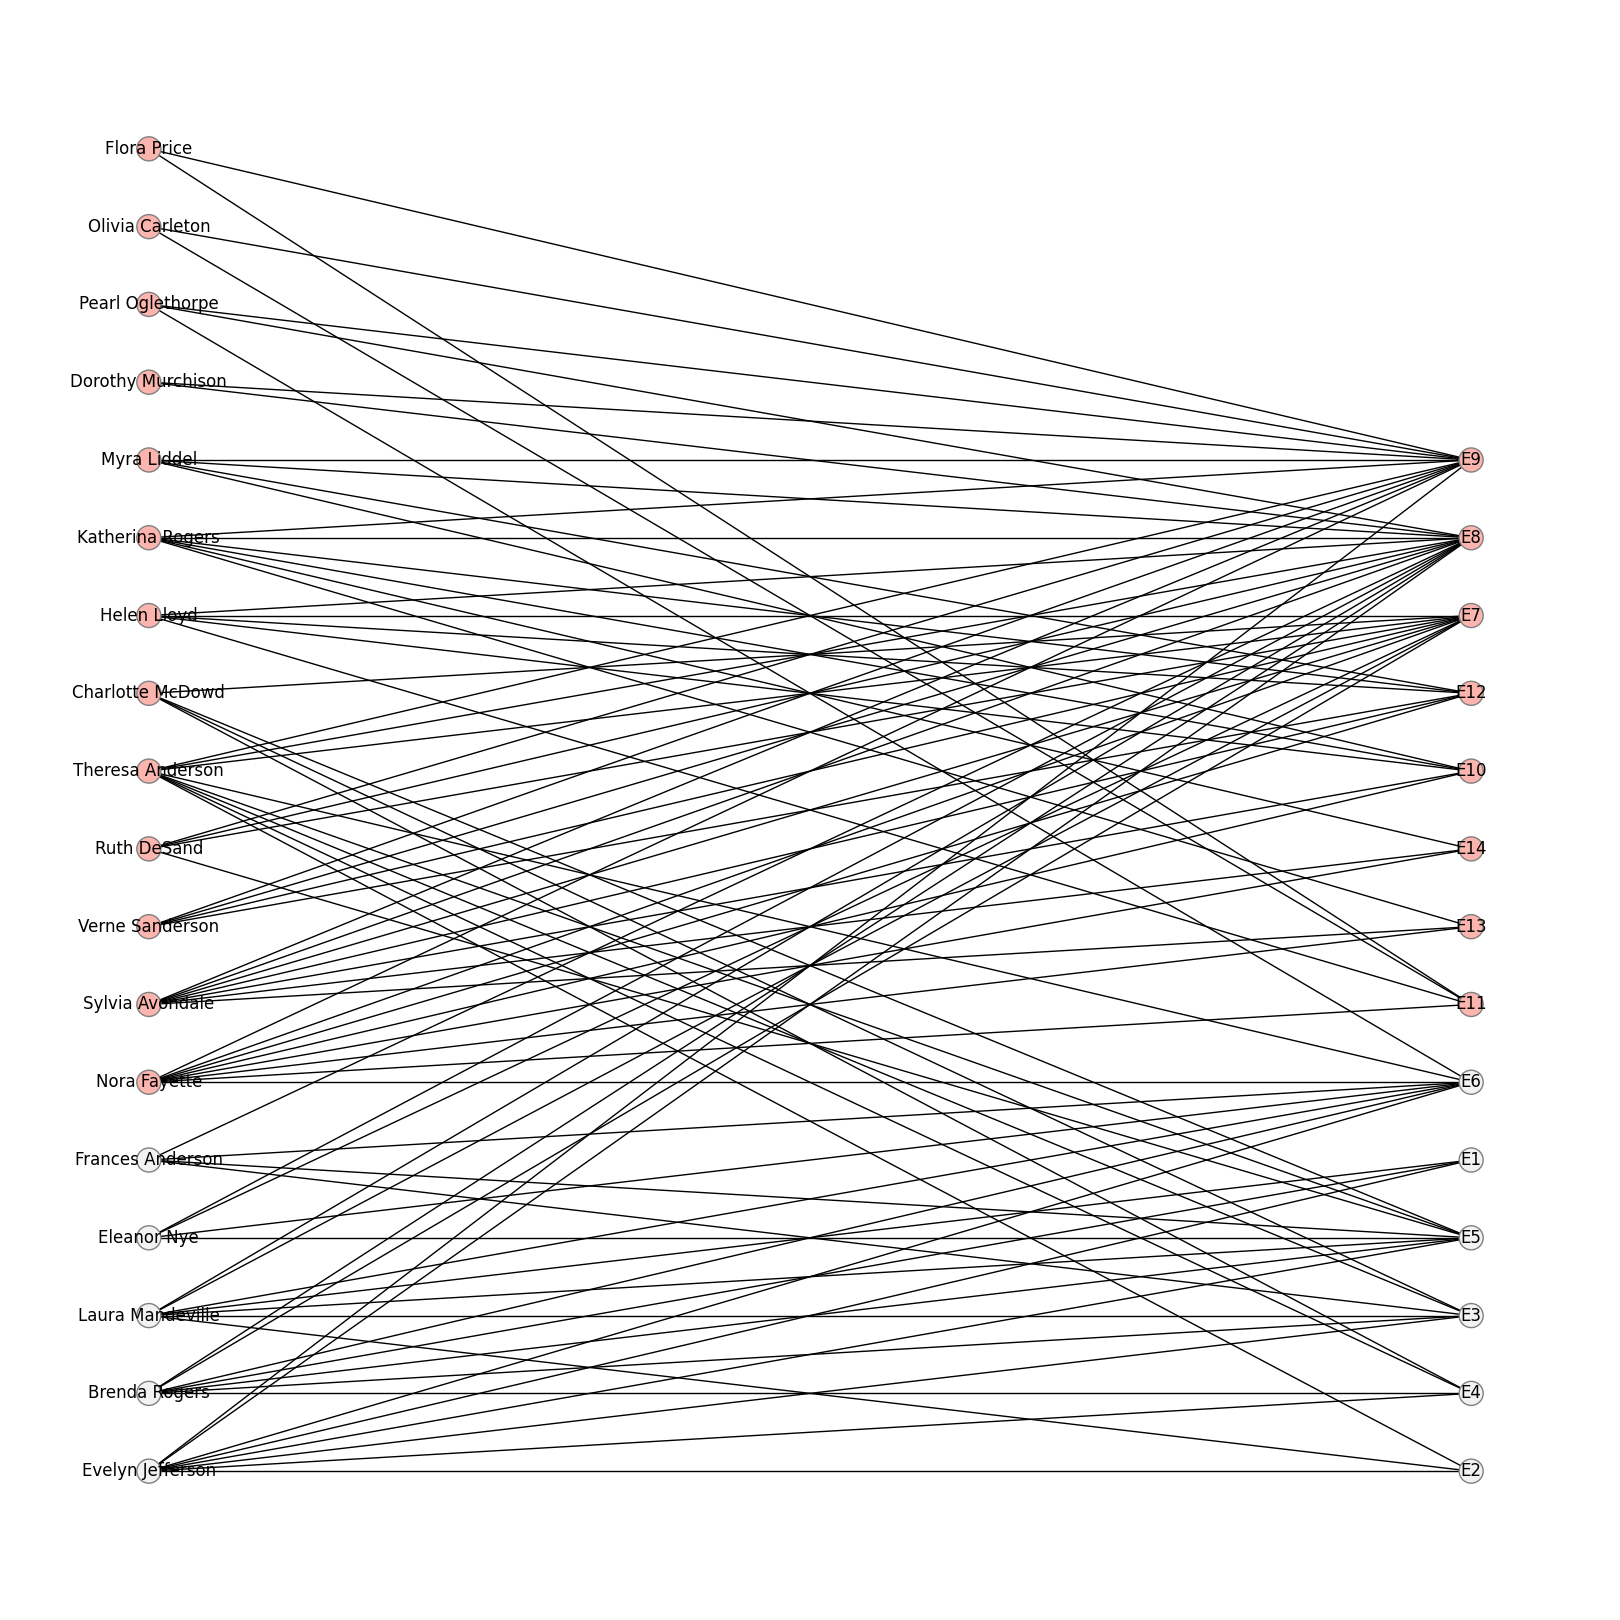

In [12]:
pos = graphing_helper.bipartite_clustered_positioning(G, INDEX)
node_colors = graphing_helper.get_colormappings(G, INDEX, [clusters[0]])

plt.figure(figsize=(16, 16))
nx.draw(G, pos=pos, with_labels=True, edge_color="black", node_color=node_colors, edgecolors='gray')